In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from time import time
from datetime import timedelta

In [4]:
import prince
import matplotlib

# 1. Loading Preprocessed Dataset and Selecting Columns from Feature Selection

In [5]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

In [6]:
df = pd.read_csv(os.path.join(data_path, "train_preprocessed.csv"), index_col=[0])

In [7]:
var_list = ['STOP_WAS_INITIATED', 'SUSPECT_ARRESTED_FLAG',
'SUSPECT_ARREST_OFFENSE', 'FRISKED_FLAG', 'SEARCHED_FLAG',
'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 'SUSPECT_SEX',
'SUSPECT_BODY_BUILD_TYPE', 
'SUSPECT_EYE_COLOR',
'SUSPECT_HAIR_COLOR','STOP_LOCATION_BORO_NAME', 'KMEANS_DEMEANOR', 'IMMEDIATE_STOP_FLAG', 'STOP_DURATION_MINUTES',
'SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'SUSPECT_WEIGHT', 'STOP_FRISK_TIME_HOUR', 'SUSPECT_RACE_DESCRIPTION']

In [8]:
df = df[df.columns.intersection(var_list)]

In [9]:
# K-means should not be numerical
df['KMEANS_DEMEANOR'] = df.KMEANS_DEMEANOR.astype('object')

In [10]:
X = df.loc[:, df.columns != 'SUSPECT_RACE_DESCRIPTION']
y = df.loc[:, 'SUSPECT_RACE_DESCRIPTION']

In [11]:
X = X.rename(columns=lambda name: name.replace('_', ''))

In [12]:
cat_col = []
for i in X.columns:
    if X[i].dtype == 'object':
        cat_col.append(i)

In [13]:
X_cat = X[cat_col]
X_cat = X_cat.drop(['IMMEDIATESTOPFLAG'], axis=1)

In [14]:
X_cat

,STOPWASINITIATED,SUSPECTARRESTEDFLAG,SUSPECTARRESTOFFENSE,FRISKEDFLAG,SEARCHEDFLAG,BACKROUNDCIRCUMSTANCESVIOLENTCRIMEFLAG,SUSPECTSEX,SUSPECTBODYBUILDTYPE,SUSPECTEYECOLOR,SUSPECTHAIRCOLOR,STOPLOCATIONBORONAME,KMEANSDEMEANOR
0,Based on Self Initiated,N,not arrested,Y,N,Y,MALE,THN,BROWN,BLK,BRONX,0
1,Based on Radio Run,N,not arrested,Y,Y,Y,MALE,HEA,BROWN,BLK,MANHATTAN,0
2,Based on C/W on Scene,Y,PETIT LARCENY,Y,Y,N,MALE,MED,OTHER,BRO,QUEENS,1
3,Based on Radio Run,N,not arrested,Y,Y,Y,MALE,THN,BROWN,BRO,STATEN ISLAND,0
4,Based on Self Initiated,Y,OTHER,N,Y,N,MALE,THN,BLACK,BLK,BROOKLYN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7630,Based on C/W on Scene,Y,ROBBERY,N,N,N,MALE,THN,BROWN,BLK,BRONX,0
7631,Based on C/W on Scene,N,not arrested,Y,N,Y,MALE,MED,unknown,OTHER,BRONX,0
7632,Based on Radio Run,Y,OTHER,Y,Y,N,MALE,THN,BROWN,BLK,BRONX,2
7633,Based on Self Initiated,N,not arrested,Y,N,N,MALE,THN,BROWN,BLK,BROOKLYN,6


# 2. MCA for categoricals

In [15]:
# MCA to reduce the dataset
import prince
mca = prince.MCA( n_components=10, n_iter=100, random_state=42, engine='auto')
mca = mca.fit(X_cat) 
mca1 = mca.transform(X_cat)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [16]:
print(mca1)

             0         1         2         3         4         5         6  \
0    -0.203749 -0.687953 -0.375000  0.266126  0.004964 -0.013176  0.102372   
1     0.041548 -0.445583  0.173772 -0.043400 -0.142778  0.162687  0.250866   
2     0.572574  0.786869  0.252810 -0.274848  0.920547  0.287868  0.231666   
3     0.096673 -0.319107  0.248961 -0.197704  0.830112  0.011733  0.449606   
4     0.584722  0.302074 -0.578606  0.155888 -0.376063 -0.420941 -0.047546   
...        ...       ...       ...       ...       ...       ...       ...   
7630  0.307105  0.088244  0.049917 -0.007872 -0.463050 -0.223845  0.289640   
7631 -0.573805 -0.360637  0.649404  0.854742 -0.148379 -0.070666 -0.015803   
7632  0.733827 -0.176579 -0.352259  0.056891  0.067983 -0.423349 -0.189881   
7633 -0.351744 -0.258865 -0.454739  0.087951  0.297555  0.213806  0.064616   
7634  0.556737  0.212491 -0.319512  0.029539 -0.332558  0.289064 -0.236318   

             7         8         9  
0     0.111535  0.136622 -

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


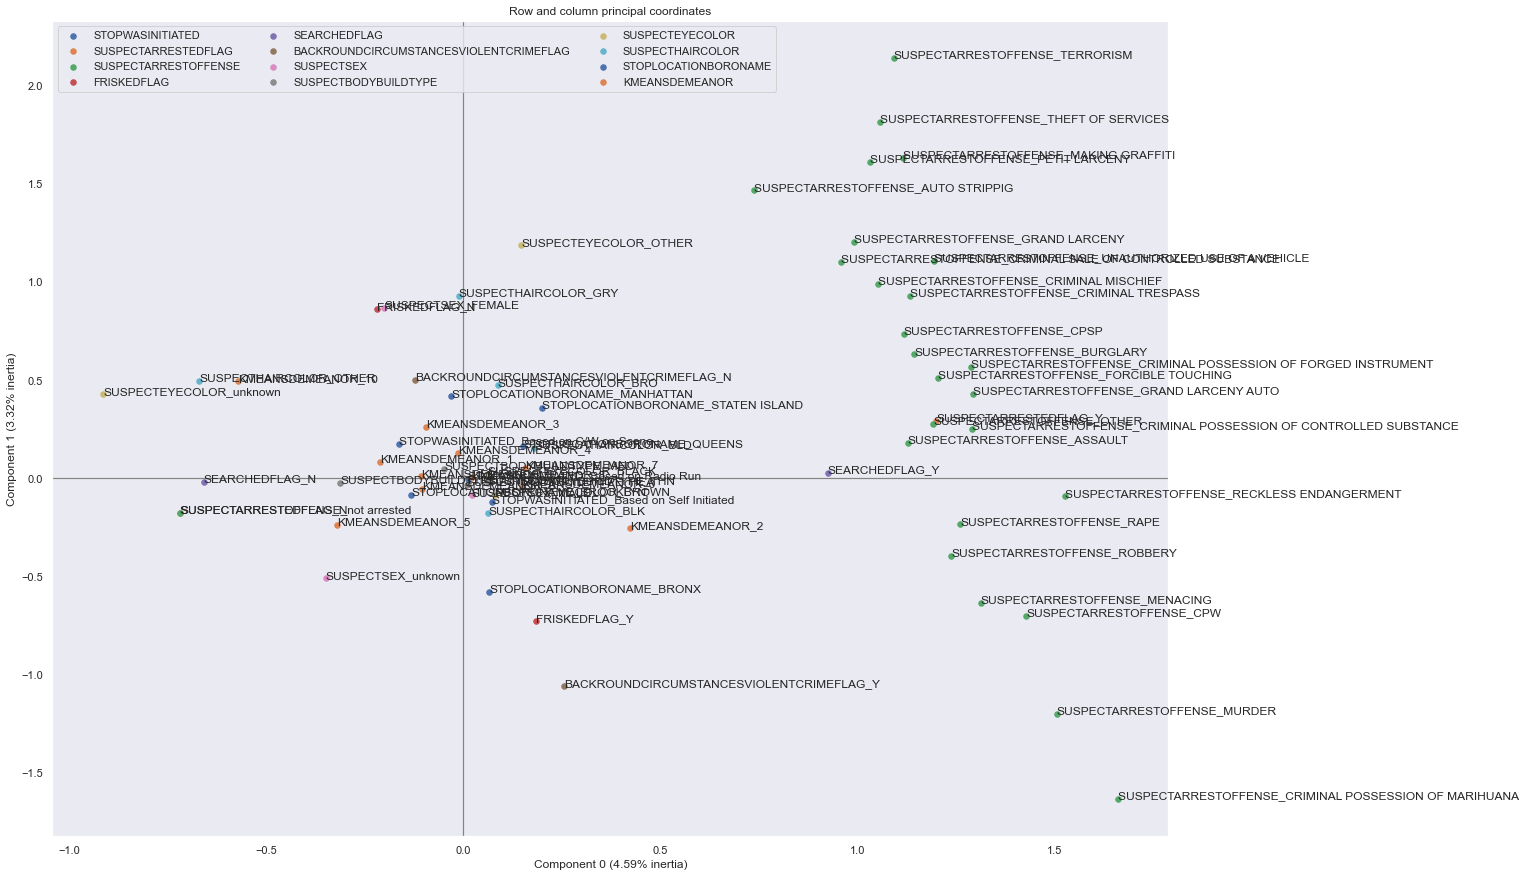

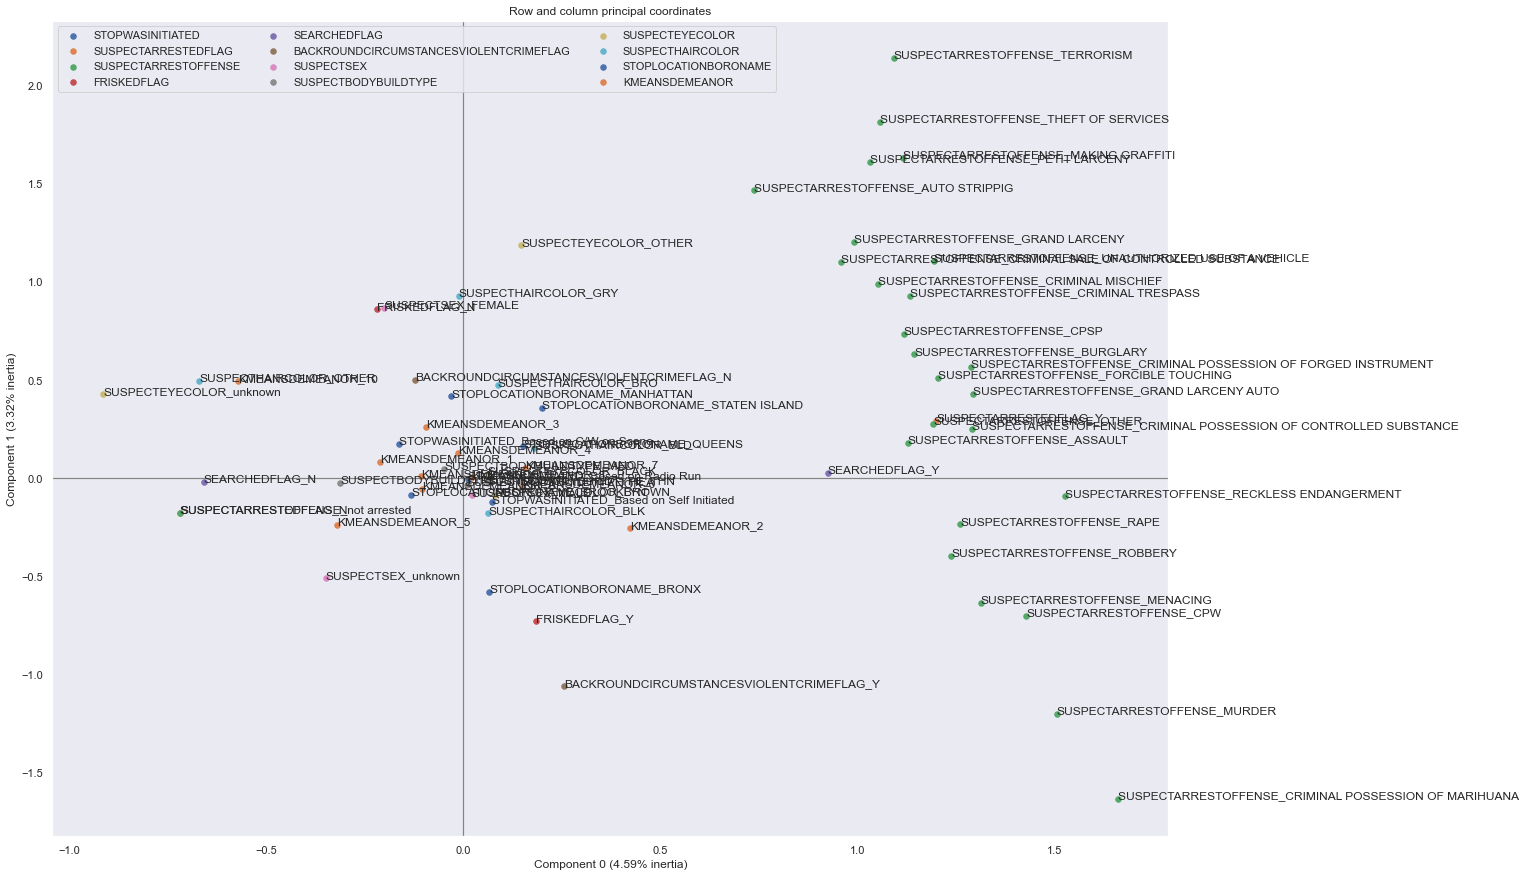

In [17]:
ax = mca.plot_coordinates(
     X=X_cat,
     ax=None,
     figsize=(20, 15),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     x_component=0,
     y_component=1,
     legend_n_cols=3
     )

ax.get_figure()

In [18]:
print(mca.total_inertia_)
print(mca.explained_inertia_)

4.75
[0.04587597609662758, 0.033222018018238986, 0.026247380458107636, 0.024246398757456593, 0.02179710365406262, 0.020884306120898585, 0.020469465543923093, 0.0200288587690213, 0.019756519362633763, 0.019424305095314457]


In [19]:
# Adding the MCA dimensions
sum(mca.explained_inertia_)

0.25195233187628463

In [20]:
final_num_col = ['STOP_DURATION_MINUTES', 'SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'SUSPECT_WEIGHT', 'STOP_FRISK_TIME_HOUR']

In [21]:
X_train_cluster = df[df.columns.intersection(final_num_col)]

In [22]:
X_train_cluster = X_train_cluster.join(mca1)

# 3. Clustering

In [23]:
index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))

results_df = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

In [24]:
X_train_cluster

,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_HEIGHT,SUSPECT_WEIGHT,STOP_FRISK_TIME_HOUR,0,1,2,3,4,5,6,7,8,9
0,5,21,6.0,170,22,-0.203749,-0.687953,-0.375000,0.266126,0.004964,-0.013176,0.102372,0.111535,0.136622,-0.042996
1,8,44,5.9,215,8,0.041548,-0.445583,0.173772,-0.043400,-0.142778,0.162687,0.250866,-0.120181,0.106642,-0.027639
2,11,31,5.8,180,11,0.572574,0.786869,0.252810,-0.274848,0.920547,0.287868,0.231666,-0.371703,-0.423528,-0.421868
3,5,19,5.7,150,9,0.096673,-0.319107,0.248961,-0.197704,0.830112,0.011733,0.449606,0.057075,0.386661,0.095942
4,10,24,5.8,190,2,0.584722,0.302074,-0.578606,0.155888,-0.376063,-0.420941,-0.047546,-0.066571,-0.102367,0.068762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,3,15,5.4,130,19,0.307105,0.088244,0.049917,-0.007872,-0.463050,-0.223845,0.289640,0.384342,0.250648,0.005948
7631,5,59,5.5,150,16,-0.573805,-0.360637,0.649404,0.854742,-0.148379,-0.070666,-0.015803,-0.138555,0.044173,0.047045
7632,41,30,5.9,175,16,0.733827,-0.176579,-0.352259,0.056891,0.067983,-0.423349,-0.189881,0.014733,0.092752,-0.322013
7633,1,18,5.8,150,23,-0.351744,-0.258865,-0.454739,0.087951,0.297555,0.213806,0.064616,0.272849,-0.082591,0.202713


In [25]:
def compute_clustering_and_plot(K, data, results):
    # Train the model
    kmeans = KMeans(n_clusters=K,max_iter=100)
    kmeans.fit(data);
    #data['kmeans_labels'] = kmeans.labels_
    
    # Compute metrics
    CH = calinski_harabasz_score(data, 
                              kmeans.labels_ )
    S = silhouette_score(data, 
                              kmeans.labels_ )
    
    DB = davies_bouldin_score(data, 
                              kmeans.labels_ )
    
    results.loc[('kmeans', k),:] = [CH,S,DB]
    return results


K_values = [2,3,4,5,10,20]


for k in K_values:
    results = compute_clustering_and_plot(k, X_train_cluster, results_df)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warning

In [26]:
results

CH score Silhouette score  DB score
model  K                                         
kmeans 3   5987.054045         0.336533   0.98075
       2   6306.980957         0.390076  0.954498
       4   5437.161902         0.279474  1.111294
       5   4884.554151         0.278285  1.119811
       10  3796.371373         0.231009  1.143423
       20  2929.269679         0.239187  1.138874

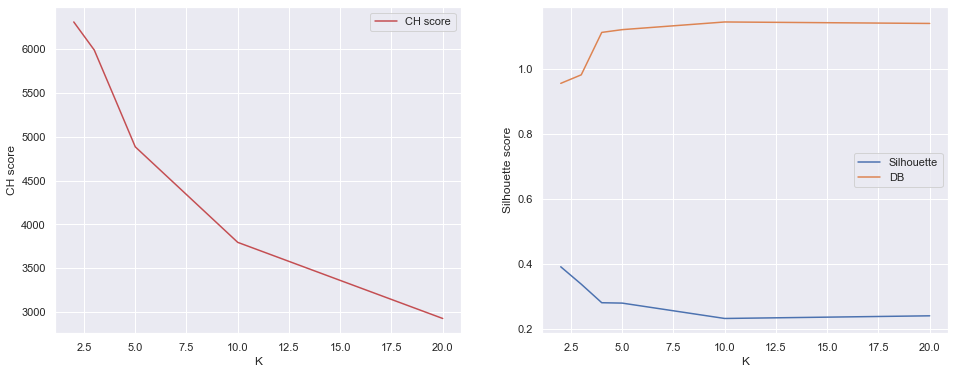

In [27]:
results = results.sort_index()
results = results.astype(float)
fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results.reset_index(),label='DB');

In [28]:
kmeans = KMeans(n_clusters=2,max_iter=5000)
kmeans.fit(X_train_cluster)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=5000, n_clusters=2)

In [29]:
X_train_cluster['kmeans_labels'] = kmeans.labels_

In [30]:
print(kmeans.labels_)
print(X_train_cluster['kmeans_labels'])

[0 1 1 ... 0 0 1]
0       0
1       1
2       1
3       0
4       1
       ..
7630    0
7631    0
7632    0
7633    0
7634    1
Name: kmeans_labels, Length: 7570, dtype: int32


In [31]:
cluster_data_label_0 = X_train_cluster.loc[kmeans.labels_ == 0, :]
cluster_data_label_1 = X_train_cluster.loc[kmeans.labels_ == 1,:]

In [32]:
mean_0 = cluster_data_label_0.mean(axis=0).round(3)
mean_1 = cluster_data_label_1.mean(axis=0)

In [33]:
pd.concat([mean_0, mean_1], axis=1)

,0,1
STOP_DURATION_MINUTES,10.255,9.975398
SUSPECT_REPORTED_AGE,27.400,33.899421
SUSPECT_HEIGHT,5.597,5.726512
SUSPECT_WEIGHT,149.831,199.614689
STOP_FRISK_TIME_HOUR,12.996,12.584660
0,0.006,-0.009650
1,0.007,-0.012536
2,-0.008,0.014645
3,0.013,-0.022545
4,0.023,-0.039236


# 4. EM Clustering

In [34]:
gm =GaussianMixture(n_components=5, 
                    covariance_type='diag').fit(X_train_cluster)
print('BIC=', gm.bic(X_train_cluster))
print('\nLOG Likelihood=', gm.lower_bound_)
print('\nWEIGHTS=')
pd.DataFrame(gm.weights_)
print('\nMEANS=')
pd.DataFrame(gm.means_)
print('\nCOV=')
pd.DataFrame(gm.covariances_)

BIC= 194816.90247344068

LOG Likelihood= -12.771303681682467

WEIGHTS=


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,0
0,0.281660
1,0.004978
2,0.177759
3,0.350241
4,0.185361



MEANS=


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,13.844450,31.845314,5.575054,148.184050,12.228377,0.081123,0.182726,0.094685,0.034610,0.063323,-0.007222,-0.015885,0.049120,0.042059,-0.029701,0.000000
1,8.310127,27.520215,5.584680,169.084808,11.389241,0.531081,0.338306,0.031020,0.134787,0.628093,-0.106012,0.789324,-0.618024,0.380051,0.874753,0.402733
2,9.933594,36.641593,5.740454,211.284230,12.948742,0.077497,0.059314,0.071984,-0.008987,-0.020317,0.126193,0.026213,-0.223802,0.077468,-0.043224,1.000000
3,7.381550,23.822431,5.614211,151.192503,13.635741,-0.059703,-0.137722,-0.091841,-0.005532,-0.015943,-0.059604,-0.008626,0.098710,-0.040164,0.003342,0.000000
4,10.040178,31.342998,5.714583,188.376688,12.230575,-0.099042,-0.083398,-0.040206,-0.037140,-0.063482,0.005426,-0.005902,-0.029931,-0.072519,0.056774,1.000000



COV=


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,125.136517,192.974164,0.097440,323.050276,54.048162,0.242084,0.159957,0.130890,0.153663,0.152886,0.171283,0.154007,0.122460,0.118213,0.102174,1.000000e-06
1,65.047697,77.723253,0.161892,1150.151131,37.075896,0.013113,0.181659,0.185884,0.122633,0.651170,1.031667,1.124418,0.823744,2.439451,3.274703,2.405402e-01
2,74.076604,155.484132,0.168891,982.054443,54.548572,0.234553,0.157267,0.141497,0.150791,0.152755,0.155091,0.139888,0.131538,0.109470,0.112719,1.000000e-06
3,25.510376,63.219979,0.107654,253.208453,56.876050,0.192140,0.119100,0.107347,0.080650,0.047596,0.025374,0.035146,0.033196,0.045166,0.041854,1.000000e-06
4,87.872111,106.552322,0.164385,113.010834,59.859190,0.179540,0.127570,0.094030,0.083728,0.050751,0.028132,0.041821,0.034921,0.050182,0.040450,1.000000e-06


In [35]:
results_df3 = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

In [36]:
for k in [2, 3, 5,10,15]:
    init_train_time = time();
    kmeans = KMeans(n_clusters=k,max_iter=1000);
    kmeans.fit(X_train_cluster);
    print('Trainin time for k={}: {}'.format(k, timedelta(seconds=time()-init_train_time)));

    CH = calinski_harabasz_score(X_train_cluster, kmeans.labels_ );
    S = silhouette_score(X_train_cluster, kmeans.labels_ );
    DB = davies_bouldin_score(X_train_cluster, kmeans.labels_ );
    
    results_df3.loc[('kmeans', k),:] = [CH,S,DB];


for k in [2, 3, 5, 10, 15]:
    init_train_time = time();
    gm =GaussianMixture(n_components=k, 
                    covariance_type='spherical')
    gm.fit(X_train_cluster);
    print('Trainin time for k={}: {}'.format(k, timedelta(seconds=time()-init_train_time)));
    prediction = gm.predict(X_train_cluster) 
    CH = calinski_harabasz_score(X_train_cluster,prediction )
    S = silhouette_score(X_train_cluster, prediction)
    DB = davies_bouldin_score(X_train_cluster, prediction)
    
    results_df3.loc[('GM', k),:] = [CH,S,DB]
    
results_df3

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=1000, n_clusters=2)

Trainin time for k=2: 0:00:00.128556


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=1000, n_clusters=3)

Trainin time for k=3: 0:00:00.103222


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=1000, n_clusters=5)

Trainin time for k=5: 0:00:00.232424


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=1000, n_clusters=10)

Trainin time for k=10: 0:00:00.425677


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=1000, n_clusters=15)

Trainin time for k=15: 0:00:00.753980


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianMixture(covariance_type='spherical', n_components=2)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Trainin time for k=2: 0:00:00.039330


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianMixture(covariance_type='spherical', n_components=3)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Trainin time for k=3: 0:00:00.041951


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianMixture(covariance_type='spherical', n_components=5)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Trainin time for k=5: 0:00:00.117262


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianMixture(covariance_type='spherical', n_components=10)

Trainin time for k=10: 0:00:00.199850


c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianMixture(covariance_type='spherical', n_components=15)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Trainin time for k=15: 0:00:00.142626


CH score Silhouette score  DB score
model  K                                         
kmeans 3   5986.753537         0.336519  0.980812
       2   6309.483938         0.390211  0.954341
       5   4884.815537         0.277654   1.11933
       10   3774.04771         0.228925  1.156009
       15  3273.438812         0.236145  1.178083
GM     2   6242.398287         0.384842  0.966736
       3   5649.018957         0.304923  1.078974
       5   4298.765731         0.231103  1.163215
       10   3549.86768          0.20566  1.253158
       15  3157.584197          0.21456   1.18272

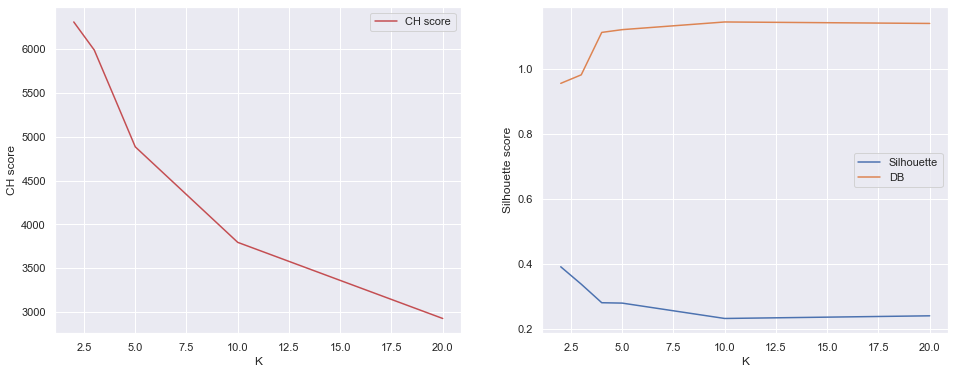

In [37]:
results = results.sort_index()
results = results.astype(float)
fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results.reset_index(),label='DB');

In [38]:
def save_mca_dataset(df, data, y_train):

    #drop cluster variable
    data = data.drop(columns = ['kmeans_labels'])

    data = pd.concat([data,y_train], axis=1)
    data = pd.concat([data, df['IMMEDIATE_STOP_FLAG']], axis=1)
    data.to_csv(os.path.join(data_path,'train_preprocessed_mca.csv'))

In [39]:
save_mca_dataset(df, X_train_cluster, y)